# Run Setup

## Run Parameters

In [31]:
#----------------------------------------------------------------------------------
run_type = 'bullet_test' # bullet_test, base_test
base_to_test = 'all' # all, train, test, other
data_date = '20240810'
#----------------------------------------------------------------------------------
input_external_customer_data = True
request_file_name = 'mock_8_request_g'
#----------------------------------------------------------------------------------
customer_id = '3681181'
#----------------------------------------------------------------------------------
income_model_version = 'v0.7'
pd_model_version = 'v0.7'
#----------------------------------------------------------------------------------

## Business Knobs

In [ ]:
#----------------------------------------------------------------------------------
GREEN_INCOME_ZONE_THRESHOLD = 0.1
RED_INCOME_ZONE_THRESHOLD = 0.5
FIN_TO_PRED_INCOME_CAP = 4
#----------------------------------------------------------------------------------
PD_AR_THRESHOLD = 0.145
PD_BINS_TO_CWF = {
    'pd_in': [0.145, 0.09, 0.045, 0.025, 0.01, 0],
    'cwf_map': [2, 2.5, 3.5, 6, 8],
    'risk_seg_map': ['Tier-5', 'Tier-4', 'Tier-3', 'Tier-2', 'Tier-1']
    }
#----------------------------------------------------------------------------------
CL_MAX_LIMIT = 500000
CL_MIN_LIMIT = 1000
#----------------------------------------------------------------------------------
LEGACY_CWF = 4
LEGACY_PD_CWF_SLOPE = 0.007
#----------------------------------------------------------------------------------

## Run Mode


In [33]:
print('')
print("*"*150)
if run_type == 'bullet_test':
    if input_external_customer_data != False:
        run_mode = 'bullet_in_detail'
        print(f'run_mode is set to {run_mode}')
        print(f"Starting a bullet test for imported client")
        print("*"*150)
    elif customer_id != '':
        run_mode = 'bullet_in_id'
        print(f'run_mode is set to {run_mode}')
        print(f'Starting a bullet test for client: {customer_id}')
        print("*"*150)
    else:
        run_mode = 'bullet_random'
        print(f'run_mode is set to {run_mode}')
        print('Starting a bullet test for a random client')
        print("*"*150)
elif run_type == 'base_test':
    run_mode = 'base_test'
    print(f'run_mode is set to {run_mode}')
    print('Starting a base test')
    print("*"*150)
else:
    raise NameError('Invalid Setup')


******************************************************************************************************************************************************
run_mode is set to bullet_in_detail
Starting a bullet test for imported client
******************************************************************************************************************************************************


# Imports & Configs

In [34]:
# Run a command in the activated environment
print('>> Starting the process to import libraries...')
import time
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import sys
import os
import joblib
import json
import re
from datetime import datetime
import yaml
from pathlib import Path
import shap
import unicodedata
import ast
import json

>> Starting the process to import libraries...


In [35]:
# paths and custom modules
t = time.time()
cwd_path = Path(os.getcwd())
data_path = cwd_path/'data/'
templates_path = cwd_path/'templates/'
objects_path = cwd_path/'objects/'
sys.path.append(os.path.dirname(cwd_path))

# pd.set_option('future.no_silent_downcasting', True)
from utils import return_catalog, build_spark_session
data_catalog, models_catalog = return_catalog()
# spark for base_test
if run_mode == 'base_test':
    print(f'<< Building Spark session.', end=' ')
    # set the pyspark path to env excutable
    conda_env_path = sys.prefix
    os.environ['PYSPARK_PYTHON'] = os.path.join(conda_env_path, 'python')
    # build spark session
    spark = build_spark_session()
    # spark imports
    import pyspark.sql.functions as F
    from pyspark.sql.types import ArrayType, StringType, DateType
    from pyspark.sql.functions import udf
    spark
print(f'<< Libraries were imported successfully.', end=' ')
print(f'(t = {(time.time()-t):.3f} seconds)')
print("*"*150)

<< Libraries were imported successfully. (t = 0.003 seconds)
******************************************************************************************************************************************************


# Functions

In [36]:
####################################################################################################################
############################################ feature_store ##########################################################
def clean_phone_numbers(df, col_name, df_engine='pandas'):
    """
    Cleans phone numbers in a dataframe column by:
    - Removing non-numeric characters
    - Retaining only the last 11 digits
    - Ensuring the phone number is valid
    
    Parameters:
    df (DataFrame): Input DataFrame (Pandas or Spark)
    col_name (str): Column name containing phone numbers
    mode (str): 'pandas' for Pandas DataFrame or 'spark' for Spark DataFrame

    Returns:
    DataFrame: DataFrame with cleaned phone numbers
    """
    if df_engine == 'pandas':
        df = df.copy()
        df[col_name] = (df[col_name]
                        .str.replace(r"\D+", "", regex=True)
                        .str[-11:]
                        .apply(lambda x: "0" + x if len(str(x)) == 10 else x))
        df.loc[df[col_name].str.len() != 11, col_name] = np.nan
        df.loc[df[col_name].apply(lambda x: len(set(str(x))) == 1), col_name] = np.nan
    elif df_engine == 'spark':
        df = df.withColumn(col_name, F.regexp_replace(F.col(col_name), r"\D+", ""))
        df = df.withColumn(col_name, F.expr(f"substring({col_name}, -11, 11)"))
        df = df.withColumn(col_name, F.when(F.length(F.col(col_name)) == 10, F.concat(F.lit("0"), F.col(col_name))).otherwise(F.col(col_name)))
        df = df.withColumn(col_name, F.when(F.length(F.col(col_name)) != 11, None).otherwise(F.col(col_name)))
        
        string_to_list = udf(lambda x: list(x) if x else [], ArrayType(StringType()))
        df = df.withColumn(col_name, F.when(F.size(F.array_distinct(string_to_list(F.col(col_name)))) == 1, None).otherwise(F.col(col_name)))
    else:
        raise ValueError("Invalid mode. Choose either 'pandas' or 'spark'.")
    return df


def stnd_missing_values_type(df):
    """
    Standardizes missing values in a DataFrame by converting them to NaN.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame to process.
    
    Returns:
    pd.DataFrame: A DataFrame with standardized missing values.
    """
    orig_dtypes = df.dtypes
    df = df.convert_dtypes()

    for col in df.columns:
        if df[col].dtype.kind in 'biufc':
            df[col] = df[col].replace([np.inf, -np.inf, 'None', '<NA>', np.nan], np.nan)
        elif df[col].dtype.kind in 'O':
            df[col] = df[col].replace(['', ' ', 'NULL', 'NaN', 'None', '<NA>', np.nan], np.nan)
        elif df[col].dtype.kind in 'M':
            df[col] = df[col].replace([pd.NaT, 'None', '<NA>', np.nan], pd.NaT)

    for col in df.columns:
        df[col] = df[col].astype(orig_dtypes[col])

    return df


def select_relevant_iscore_columns(df):
    return df[['client_id','is_iscore', 'iscore_score', 'iscore_report']]

def update_no_hit_consumers(df):
    no_hit_mask = df['iscore_report'].str.contains('iScoreNohitConsumer') | df['iscore_report'].str.contains('Response NoHit')
    df.loc[no_hit_mask, 'is_iscore'] = 0
    df = df[df['is_iscore'] == 1]
    return df

def update_iscore_report_format(df):
    data_packet_mask = df['iscore_report'].str.contains('<DATAPACKET>')
    df['is_iscore_new_format'] = (~data_packet_mask).astype('int16')
    iscore_nohit_mask = df['is_iscore'] == 0
    df.loc[iscore_nohit_mask, 'is_iscore_new_format'] = np.nan
    return df

def process_open_accounts_old_format(df):
    def extract_open_accounts_old(report):
        try:
            CONSUMER_CREDIT_FACILITY = report.split('CONSUMER_CREDIT_FACILITY')[1]
        except IndexError:
            return pd.Series({
                'OpenAccounts_count_old': 0,
                'OpenAccounts_ApprovalAmount_sum_old': 0,
                'OpenAccounts_BalanceAmount_sum_old': 0,
                'OpenAccounts_InstallmentAmount_sum_old': 0,
                'OpenAccounts_MaxDaysDue_sum_old': 0,
            }, dtype='float64')

        def extract_sum(pattern, data):
            matches = re.findall(pattern, data)
            return sum(int(x) for x in matches if x.isdigit()) if matches else 0

        OpenAccounts_count_old = len(re.findall(r'CREDIT_DETAILS ID', CONSUMER_CREDIT_FACILITY))
        OpenAccounts_ApprovalAmount_sum_old = extract_sum(r'<APPROVAL_AMOUNT>(.*?)</APPROVAL_AMOUNT>', CONSUMER_CREDIT_FACILITY)
        OpenAccounts_BalanceAmount_sum_old = extract_sum(r'<CURRENT_BALANCE>(.*?)</CURRENT_BALANCE>', CONSUMER_CREDIT_FACILITY)
        OpenAccounts_InstallmentAmount_sum_old = extract_sum(r'<AMT_OF_INSTALMENT>(.*?)</AMT_OF_INSTALMENT>', CONSUMER_CREDIT_FACILITY)
        OpenAccounts_MaxDaysDue_sum_old = extract_sum(r'<MAX_NUM_DAYS_DUE>(.*?)</MAX_NUM_DAYS_DUE>', CONSUMER_CREDIT_FACILITY)

        return pd.Series({
            'OpenAccounts_count_old': float(OpenAccounts_count_old),
            'OpenAccounts_ApprovalAmount_sum_old': float(OpenAccounts_ApprovalAmount_sum_old),
            'OpenAccounts_BalanceAmount_sum_old': float(OpenAccounts_BalanceAmount_sum_old),
            'OpenAccounts_InstallmentAmount_sum_old': float(OpenAccounts_InstallmentAmount_sum_old),
            'OpenAccounts_MaxDaysDue_sum_old': float(OpenAccounts_MaxDaysDue_sum_old),
        })

    columns = [
        'OpenAccounts_count_old',
        'OpenAccounts_ApprovalAmount_sum_old',
        'OpenAccounts_BalanceAmount_sum_old',
        'OpenAccounts_InstallmentAmount_sum_old',
        'OpenAccounts_MaxDaysDue_sum_old'
    ]
    for col in columns:
        df[col] = np.nan

    mask = (df['is_iscore'] == 1) & (df['is_iscore_new_format'] == 0)
    df.loc[mask, columns] = df.loc[mask, 'iscore_report'].apply(extract_open_accounts_old)
    df[columns] = df[columns].fillna(0).astype('int64')

    return df

def process_closed_accounts_old_format(df):
    def extract_closed_accounts_old(report):
        parts = report.split('CONSUMER_CLOSED_ACCOUNT')
        if len(parts) == 3:
            CONSUMER_CLOSED_ACCOUNT = parts[1]
        else:
            return pd.Series({
                'ClosedAccounts_count_old': 0,
                'ClosedAccounts_ApprovalAmount_sum_old': 0,
                'ClosedAccounts_InstallmentAmount_sum_old': 0,
                'ClosedAccounts_MaxDaysDue_sum_old': 0,
            }, dtype='float64')

        def extract_sum(pattern, data):
            matches = re.findall(pattern, data)
            return sum(int(x) for x in matches if x.isdigit()) if matches else 0

        ClosedAccounts_count_old = len(re.findall(r'CLOSED_ACCOUNTS ID', CONSUMER_CLOSED_ACCOUNT))
        ClosedAccounts_ApprovalAmount_sum_old = extract_sum(r'<APPROVAL_AMOUNT>(.*?)</APPROVAL_AMOUNT>', CONSUMER_CLOSED_ACCOUNT)
        ClosedAccounts_InstallmentAmount_sum_old = extract_sum(r'<AMT_OF_INSTALMENT>(.*?)</AMT_OF_INSTALMENT>', CONSUMER_CLOSED_ACCOUNT)
        ClosedAccounts_MaxDaysDue_sum_old = extract_sum(r'<MAX_NUM_DAYS_DUE>(.*?)</MAX_NUM_DAYS_DUE>', CONSUMER_CLOSED_ACCOUNT)

        return pd.Series({
            'ClosedAccounts_count_old': float(ClosedAccounts_count_old),
            'ClosedAccounts_ApprovalAmount_sum_old': float(ClosedAccounts_ApprovalAmount_sum_old),
            'ClosedAccounts_InstallmentAmount_sum_old': float(ClosedAccounts_InstallmentAmount_sum_old),
            'ClosedAccounts_MaxDaysDue_sum_old': float(ClosedAccounts_MaxDaysDue_sum_old),
        })

    columns = [
        'ClosedAccounts_count_old',
        'ClosedAccounts_ApprovalAmount_sum_old',
        'ClosedAccounts_InstallmentAmount_sum_old',
        'ClosedAccounts_MaxDaysDue_sum_old'
    ]
    for col in columns:
        df[col] = np.nan

    mask = (df['is_iscore'] == 1) & (df['is_iscore_new_format'] == 0)
    df.loc[mask, columns] = df.loc[mask, 'iscore_report'].apply(extract_closed_accounts_old)
    df[columns] = df[columns].fillna(0).astype('int64')

    return df


def process_open_accounts_new_format(df):
    def extract_open_accounts_new(report):  
        # Try to load JSON data, fallback to raw report on failure
        try:  
            report = json.loads(report)
        except json.JSONDecodeError:
            return pd.Series({
                'OpenAccounts_count_new': 0,
                'OpenAccounts_ApprovalAmount_sum_new': 0,
                'OpenAccounts_BalanceAmount_sum_new': 0,
                'OpenAccounts_InstallmentAmount_sum_new': 0,
                'OpenAccounts_MaxDaysDue_sum_new': 0,
            }, dtype='float64')

        # Initialize variables
        CreditFacilities = []
        OpenAccount = []

        # Extract CreditFacilities from the report
        if isinstance(report, list):
            for module in report:
                if isinstance(module, dict) and module.get('ModuleId') == 'iScoreCreditProfileOverviewConsumer':
                    content = module.get('Content', {})
                    data = content.get('DATA', [{}])
                    CreditFacilities = data[0].get('CreditFacilities', [])
                    OpenAccount = data[0].get('OpenAccount', [])

        # Define helper function for parsing integers
        def try_parse_int(s):
            try:
                return int(s)
            except ValueError:
                return 0

        # Calculate results
        result = {
            'OpenAccounts_count_new': sum(try_parse_int(x.get('NoOfAccounts', 0)) for x in CreditFacilities),
            'OpenAccounts_ApprovalAmount_sum_new': sum(try_parse_int(x.get('TotalApprovalAmt', 0)) for x in CreditFacilities),
            'OpenAccounts_BalanceAmount_sum_new': sum(try_parse_int(x.get('TotalBalanceAmount', 0)) for x in CreditFacilities),
            'OpenAccounts_InstallmentAmount_sum_new': sum(try_parse_int(x.get('TotalMonthlyInstallmentAmt', 0)) for x in CreditFacilities),
            'OpenAccounts_MaxDaysDue_sum_new': sum(try_parse_int(x.get('MAX_NUM_DAYS_DUE', 0)) for x in OpenAccount) if OpenAccount else 0,
        }
        
        return pd.Series(result)

    # Define columns
    columns = [
        'OpenAccounts_count_new',
        'OpenAccounts_ApprovalAmount_sum_new',
        'OpenAccounts_BalanceAmount_sum_new',
        'OpenAccounts_InstallmentAmount_sum_new',
        'OpenAccounts_MaxDaysDue_sum_new'
    ]

    # Initialize columns with NaN values
    for col in columns:
        df[col] = np.nan

    # Apply extraction logic
    mask = (df['is_iscore'] == 1) & (df['is_iscore_new_format'] == 1)
    result = df.loc[mask, 'iscore_report'].apply(extract_open_accounts_new)
    result_df = pd.DataFrame(result, index=df.loc[mask].index)
    
    # Update the DataFrame with results
    df.loc[mask, columns] = result_df.fillna(0).astype('int64')

    # Fill NaN values for all rows in the specified columns
    df[columns] = df[columns].fillna(0).astype('int64')

    return df

def process_closed_accounts_new_format(df):
    def extract_closed_accounts_new(report):
        # Try to load JSON data, fallback to raw report on failure
        try:  
            report = json.loads(report)
        except json.JSONDecodeError:
            return pd.Series({
                'ClosedAccounts_count_new': 0,
                'ClosedAccounts_ApprovalAmount_sum_new': 0,
                'ClosedAccounts_InstallmentAmount_sum_new': 0,
                'ClosedAccounts_MaxDaysDue_sum_new': 0,
            }, dtype='float64')

        # Initialize variables
        ClosedAccountDetails = []

        # Extract ClosedAccountDetails from the report
        if isinstance(report, list):
            for module in report:
                if isinstance(module, dict) and module.get('ModuleId') == 'iScoreClosedFacilitiesConsumer':
                    content = module.get('Content', {})
                    data = content.get('DATA', [{}])
                    ClosedAccountDetails = data[0].get('ClosedAccountDetails', [])

        # Define helper function for parsing integers
        def try_parse_int(s):
            try:
                return int(s)
            except ValueError:
                return 0

        # Calculate results
        if ClosedAccountDetails:
            result = {
                'ClosedAccounts_count_new': len(ClosedAccountDetails),
                'ClosedAccounts_ApprovalAmount_sum_new': sum(try_parse_int(x.get('SANCTION_AMT', 0)) for x in ClosedAccountDetails),
                'ClosedAccounts_InstallmentAmount_sum_new': sum(try_parse_int(x.get('AMT_OF_INSTALMENT', 0)) for x in ClosedAccountDetails if x.get('AMT_OF_INSTALMENT')),
                'ClosedAccounts_MaxDaysDue_sum_new': sum(try_parse_int(x.get('MAX_NUM_DAYS_DUE', 0)) for x in ClosedAccountDetails)
            }
        else:
            result = {
                'ClosedAccounts_count_new': 0,
                'ClosedAccounts_ApprovalAmount_sum_new': 0,
                'ClosedAccounts_InstallmentAmount_sum_new': 0,
                'ClosedAccounts_MaxDaysDue_sum_new': 0
            }
        
        return pd.Series(result)

    # Define columns
    columns = [
        'ClosedAccounts_count_new',
        'ClosedAccounts_ApprovalAmount_sum_new',
        'ClosedAccounts_InstallmentAmount_sum_new',
        'ClosedAccounts_MaxDaysDue_sum_new'
    ]

    # Initialize columns with NaN values
    for col in columns:
        df[col] = np.nan

    # Apply extraction logic
    mask = (df['is_iscore'] == 1) & (df['is_iscore_new_format'] == 1)
    result = df.loc[mask, 'iscore_report'].apply(extract_closed_accounts_new)
    result_df = pd.DataFrame(result, index=df.loc[mask].index)

    # Update the DataFrame with results
    df.loc[mask, columns] = result_df.fillna(0).astype('int64')

    # Fill NaN values for all rows in the specified columns
    df[columns] = df[columns].fillna(0).astype('int64')

    return df


def combine_old_and_new_formats(df):
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    # Define the column mappings for open and closed accounts
    open_accounts_old = {
        'OpenAccounts_count': 'OpenAccounts_count_old',
        'OpenAccounts_ApprovalAmount_sum': 'OpenAccounts_ApprovalAmount_sum_old',
        'OpenAccounts_BalanceAmount_sum': 'OpenAccounts_BalanceAmount_sum_old',
        'OpenAccounts_InstallmentAmount_sum': 'OpenAccounts_InstallmentAmount_sum_old',
        'OpenAccounts_MaxDaysDue_sum': 'OpenAccounts_MaxDaysDue_sum_old'
    }
    
    open_accounts_new = {
        'OpenAccounts_count': 'OpenAccounts_count_new',
        'OpenAccounts_ApprovalAmount_sum': 'OpenAccounts_ApprovalAmount_sum_new',
        'OpenAccounts_BalanceAmount_sum': 'OpenAccounts_BalanceAmount_sum_new',
        'OpenAccounts_InstallmentAmount_sum': 'OpenAccounts_InstallmentAmount_sum_new',
        'OpenAccounts_MaxDaysDue_sum': 'OpenAccounts_MaxDaysDue_sum_new'
    }
    
    closed_accounts_old = {
        'ClosedAccounts_count': 'ClosedAccounts_count_old',
        'ClosedAccounts_ApprovalAmount_sum': 'ClosedAccounts_ApprovalAmount_sum_old',
        'ClosedAccounts_InstallmentAmount_sum': 'ClosedAccounts_InstallmentAmount_sum_old',
        'ClosedAccounts_MaxDaysDue_sum': 'ClosedAccounts_MaxDaysDue_sum_old'
    }
    
    closed_accounts_new = {
        'ClosedAccounts_count': 'ClosedAccounts_count_new',
        'ClosedAccounts_ApprovalAmount_sum': 'ClosedAccounts_ApprovalAmount_sum_new',
        'ClosedAccounts_InstallmentAmount_sum': 'ClosedAccounts_InstallmentAmount_sum_new',
        'ClosedAccounts_MaxDaysDue_sum': 'ClosedAccounts_MaxDaysDue_sum_new'
    }

    # Fill NaN values with 0
    df = df.fillna(0)

    # Combine old and new format columns
    for combined_col, old_col in open_accounts_old.items():
        new_col = open_accounts_new[combined_col]
        df[combined_col] = df[old_col] + df.get(new_col, 0)

    for combined_col, old_col in closed_accounts_old.items():
        new_col = closed_accounts_new[combined_col]
        df[combined_col] = df[old_col] + df.get(new_col, 0)
    
    # Drop old and new format columns
    old_new_columns = [col for col in df.columns if 'old' in col or 'new' in col]
    df = df.drop(columns=old_new_columns)
    
    return df

def new_report_to_json(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform the 'iscore_report' column for rows where 'is_iscore_new_format' == 1.
    Converts valid string representations of dictionaries to JSON-like strings.

    Parameters:
    df (pd.DataFrame): Input DataFrame with 'iscore_report' and 'is_iscore_new_format' columns.

    Returns:
    pd.DataFrame: Transformed DataFrame with updated 'iscore_report' where applicable.
    """

    def parse_and_convert_to_json(report):
        """Parse the report using ast and convert it to a JSON-like string."""
        try:
            parsed_data = ast.literal_eval(report)
            return json.dumps(parsed_data, ensure_ascii=False)
        except (ValueError, SyntaxError) as e:
            # print(f"Error parsing report: {e}")
            return report  # Handle errors gracefully

    # Apply the transformation only to rows where 'is_iscore_new_format' == 1
    df.loc[df['is_iscore_new_format'] == 1, 'iscore_report'] = (
        df.loc[df['is_iscore_new_format'] == 1, 'iscore_report']
        .apply(parse_and_convert_to_json)
    )
    
    return df

def process_iscore(df, full_df=False):
    df = df.copy()
    
    # Preserve original DataFrame without specific columns
    df_org = df.drop(columns=['is_iscore', 'iscore_score', 'iscore_report'])
    df = df[df['is_iscore'] == 1]

    df = select_relevant_iscore_columns(df)
    df = update_no_hit_consumers(df)
    df = update_iscore_report_format(df)
    df = new_report_to_json(df)
    df = process_open_accounts_old_format(df)
    df = process_closed_accounts_old_format(df)
    df = process_open_accounts_new_format(df)
    df = process_closed_accounts_new_format(df)
    df = combine_old_and_new_formats(df)
    
    # Fill missing values and drop unnecessary columns
    df = df.fillna(0)
    df = df.drop(columns=['iscore_report'], errors='ignore')  # Use errors='ignore' to handle cases where the column may not exist
    
    # Merge with the original DataFrame if full_df is True
    if full_df:
        df_final = df_org.merge(df, on='client_id', how='left')
        df_final['is_iscore'] = df_final['is_iscore'].fillna(0)
    else:
        df_final = df
    
    return df_final

def adjust_date_range(df, column, df_engine='spark'):
    """Adjusts the date range of a given column in a DataFrame."""
    if df_engine == 'spark':
        df = df.withColumn(column, 
                           F.when(F.year(df[column]) < 1970, F.lit("1970-01-01").cast(DateType()))
                           .otherwise(df[column]))
        df = df.withColumn(column, 
                           F.when(F.year(df[column]) > 2038, F.lit("2038-12-31").cast(DateType()))
                           .otherwise(df[column]))
    elif df_engine == 'pandas':
        df[column] = pd.to_datetime(df[column])
        df.loc[df[column].dt.year < 1970, column] = pd.Timestamp("1970-01-01")
        df.loc[df[column].dt.year > 2038, column] = pd.Timestamp("2038-12-31")
    return df

def filter_transactions(df, df_cust, df_engine='spark'):
    """Filters out past transactions based on customer data."""
    if df_engine == 'spark':
        df_cust_1 = df_cust.selectExpr("client_id as client_id_1", "phone_number_1 as phone", "contract_date as contract_date_1").dropna(subset=["phone"])
        df_cust_2 = df_cust.selectExpr("client_id as client_id_2", "phone_number_2 as phone", "contract_date as contract_date_2").dropna(subset=["phone"])

        df = df.join(F.broadcast(df_cust_1), df.customer_phone == df_cust_1.phone, how='left')
        df = df.join(F.broadcast(df_cust_2), df.customer_phone == df_cust_2.phone, how='left')

        df = df.withColumn("client_id", F.coalesce(df.client_id_1, df.client_id_2))
        df = df.drop("client_id_1", "client_id_2")

        df = df.withColumn("contract_date", F.coalesce(df.contract_date_1, df.contract_date_2))
        
        # Check if 'phone' column exists before dropping
        if 'phone' in df.columns:
            df = df.drop("contract_date_1", "contract_date_2", "phone")
        else:
            df = df.drop("contract_date_1", "contract_date_2")

        df = df.withColumn("trx_date", df["trx_date"].cast(DateType()))
        df = df.withColumn("contract_date", df["contract_date"].cast(DateType()))

        df = df.filter(df.trx_date < df.contract_date)
        df = df.withColumn("days_from_last_trx", F.datediff(df["contract_date"], df["trx_date"]))
        df = df.filter(df.days_from_last_trx > 1)
    elif df_engine == 'pandas':
        df_cust_1 = df_cust[['client_id', 'phone_number_1', 'contract_date']].rename(columns={'client_id': 'client_id_1', 'phone_number_1': 'phone', 'contract_date': 'contract_date_1'}).dropna(subset=['phone'])
        df_cust_2 = df_cust[['client_id', 'phone_number_2', 'contract_date']].rename(columns={'client_id': 'client_id_2', 'phone_number_2': 'phone', 'contract_date': 'contract_date_2'}).dropna(subset=['phone'])

        df = df.merge(df_cust_1, left_on='customer_phone', right_on='phone', how='left')
        df = df.merge(df_cust_2, left_on='customer_phone', right_on='phone', how='left')

        df['client_id'] = df[['client_id_1', 'client_id_2']].apply(lambda x: x.dropna().iloc[0] if not x.dropna().empty else None, axis=1)
        df = df.drop(columns=['client_id_1', 'client_id_2'])

        df['contract_date'] = df['contract_date_1'].combine_first(df['contract_date_2'])
        
        # Check if 'phone' column exists before dropping
        columns_to_drop = ['contract_date_1', 'contract_date_2', 'phone']
        existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
        df = df.drop(columns=existing_columns_to_drop)

        df['trx_date'] = pd.to_datetime(df['trx_date'])
        df['contract_date'] = pd.to_datetime(df['contract_date'])

        df = df[df['trx_date'] < df['contract_date']]
        df['days_from_last_trx'] = (df['contract_date'] - df['trx_date']).dt.days
        df = df[df['days_from_last_trx'] > 1]
    return df

def aggregate_transactions(df, df_engine='spark'):
    """Aggregates transaction data by client id."""
    if df_engine == 'spark':
        df = df.groupBy("client_id").agg(
            F.datediff(F.min("contract_date"), F.min("trx_date")).alias("days_from_first_trx"),
            F.datediff(F.max("contract_date"), F.max("trx_date")).alias("days_from_last_trx"),
            F.sum(F.when(df.online_vs_branch == 1, 1).otherwise(0)).alias("n_trx_online"),
            F.sum(F.when(df.online_vs_branch == 2, 1).otherwise(0)).alias("n_trx_branch"),
            F.sum(F.when(df.net_sales > 0, df.net_sales).otherwise(0)).alias("net_sales_pos"),
            F.sum(F.when(df.net_sales < 0, df.net_sales).otherwise(0)).alias("net_sales_neg"),
            F.sum(F.when(df.net_qty > 0, df.net_qty).otherwise(0)).alias("net_qty_pos"),
            F.sum(F.when(df.net_qty < 0, df.net_qty).otherwise(0)).alias("net_qty_neg")
        )
    elif df_engine == 'pandas':
        df['days_from_first_trx'] = (df.groupby('client_id')['contract_date'].transform('min') - df.groupby('client_id')['trx_date'].transform('min')).dt.days
        df['days_from_last_trx'] = (df.groupby('client_id')['contract_date'].transform('max') - df.groupby('client_id')['trx_date'].transform('max')).dt.days
        df['n_trx_online'] = df[df['online_vs_branch'] == 1].groupby('client_id')['online_vs_branch'].transform('count')
        df['n_trx_branch'] = df[df['online_vs_branch'] == 2].groupby('client_id')['online_vs_branch'].transform('count')
        df['net_sales_pos'] = df[df['net_sales'] > 0].groupby('client_id')['net_sales'].transform('sum')
        df['net_sales_neg'] = df[df['net_sales'] < 0].groupby('client_id')['net_sales'].transform('sum')
        df['net_qty_pos'] = df[df['net_qty'] > 0].groupby('client_id')['net_qty'].transform('sum')
        df['net_qty_neg'] = df[df['net_qty'] < 0].groupby('client_id')['net_qty'].transform('sum')
        df = df.drop_duplicates(subset=['client_id'])
    return df

def process_transactions_data(df, df_cust, df_engine='spark'):
    """Processes transactions data"""
    df = adjust_date_range(df, "trx_date", df_engine)
    df = filter_transactions(df, df_cust, df_engine)
    df = aggregate_transactions(df, df_engine)

    if df_engine == 'spark':
        # Get numeric columns
        numeric_columns = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'double']]
        # Apply abs and round functions to numeric columns
        for column in numeric_columns:
            df = df.withColumn(column, F.round(F.abs(F.col(column)), 1))
        df = df.toPandas()
    elif df_engine == 'pandas':
        numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
        df[numeric_columns] = df[numeric_columns].abs().round(1)

    return df

def adjust_ssn(df):
    df['ssn'] = df['ssn'].str[-14:]
    return df

def calculate_age(df, data_date):
    df['ssn_century_birth'] = df['ssn'].str[0]
    df['ssn_date_birth'] = df['ssn'].str[1:7]
    df['ssn_date_birth'] = np.where(
        df['ssn_century_birth'] == '3',
        '20' + df['ssn_date_birth'],
        '19' + df['ssn_date_birth']
    )
    data_date = datetime.strptime(data_date, '%Y%m%d')
    df['ssn_date_birth'] = pd.to_datetime(df['ssn_date_birth'], errors='coerce')
    df['contract_date'] = pd.to_datetime(df['contract_date'])
    df['age_at_contract'] = df['contract_date'].dt.year - df['ssn_date_birth'].dt.year
    df['age_at_data_date'] = data_date.year - df['ssn_date_birth'].dt.year
    return df

def map_governorate(df, df2):
    df['ssn_governorate_code'] = df['ssn'].str[7:9]
    df['ssn_governorate_code'] = df['ssn_governorate_code'].astype(int)
    df = df.merge(df2, how='left', on='ssn_governorate_code')
    return df

def determine_gender(df):
    df['ssn_gender_code'] = df['ssn'].str[12]
    df['ssn_gender'] = np.where(df['ssn_gender_code'].astype(int) % 2 == 0, 'female', 'male')
    df['ssn_gender'] = df['ssn_gender'].map({'male': 1, 'female': 0})
    df = df.rename(columns={'ssn_gender': 'ssn_is_male'})
    return df

def process_ssn_data(df, ssn_gov_map_df, data_date):
    df = df[['client_id', 'ssn', 'contract_date']].copy()
    df = adjust_ssn(df)
    df = calculate_age(df, data_date)
    df = map_governorate(df, ssn_gov_map_df)
    df = determine_gender(df)
    df = df[['client_id', 'ssn_is_male', 'ssn_governorate', 'age_at_contract']]
    return df

def adj_income_data(df, ssn_df):
    """
    Adjusts income data by renaming columns and merging with another DataFrame.
    # """
    if 'last_income_up_date' not in df.columns:
        df['last_income_up_date'] = df['contract_date']
        df['net_income_last'] = df['net_income']
        df['net_burden_last'] = df['net_burden']
    if 'first_income_up_date' not in df.columns:
        df['first_income_up_date'] = df['contract_date']
        df['net_income_first'] = df['net_income']
        df['net_burden_first'] = df['net_burden']

    df = df[['client_id', 'net_income_first','net_income', 'net_burden',
        'net_income_last',  'net_burden_last', 'last_income_up_date',
        #'ss_min_income', 'ss_max_income',
        'job_map_min_salary', 'job_map_max_salary'
        ]].copy()
    # df['net_income'] = df['net_income_last'] # line only for training not prod
    # df['net_burden'] = df['net_burden_last'] # line only for training not prod
        
    df = df.merge(ssn_df[['client_id', 'age_at_contract']], on='client_id', how='left')
    
    return df

def apply_inflation(df, data_date, inflation_rate=0.20):
    """
    Applies an inflation factor to all value columns in a DataFrame based on the year of each record.
    """
    df['last_income_up_date'] = pd.to_datetime(df['last_income_up_date'])
    df['Year'] = df['last_income_up_date'].dt.year
    data_date = datetime.strptime(data_date, '%Y%m%d')
    data_date_year = data_date.year
    df['YearsFromNow'] = data_date_year - df['Year']
    # account for retirement age
    df['YearsFromNow'] = np.where(df['age_at_contract'] + df['YearsFromNow'] > 60, 
                                  60 - df['age_at_contract'], 
                                  df['YearsFromNow'])
    # If 'YearsFromNow' is negative, set it to 0
    df['YearsFromNow'] = np.where(df['YearsFromNow'] < 0, 0, df['YearsFromNow'])
    # calculate inflation based on compounded interest
    df['InflationFactor'] = (1 + inflation_rate) ** df['YearsFromNow']
    # Only inflate 'net_income' and 'net_burden' columns
    value_cols = ['net_income', 'net_burden']
    for value_col in value_cols:
        inflated_value = (df[value_col] * df['InflationFactor']).round(0)
        # Drop rows with non-finite values
        inflated_value = inflated_value.replace([np.inf, -np.inf], np.nan).dropna()
        df[value_col + '_inflated'] = inflated_value.astype(int)
    df = df.drop(columns=['Year', 'YearsFromNow', 'InflationFactor'])
    return df

def add_ss_data(df):
    df = df.copy()
    # TODO those three lines are only for training
    #df = df[df['ss_min_income'].notna() & (df['ss_min_income'] != 0)]
    #df.loc[df['net_income_inflated'] < df['ss_min_income'], 'net_income_inflated'] = df['ss_min_income']
    #df.loc[(df['net_income_inflated'] > df['ss_max_income']) & (df['net_income_inflated'] > 100000), 'net_income_inflated'] = 100000
    return df

def process_income_data(df, ssn_df, data_date, inflation_rate=0.20):
    """
    Processes income data by adjusting income data, applying inflation, and adding social security data.
    """
    df = adj_income_data(df, ssn_df)
    df = apply_inflation(df, data_date, inflation_rate)
    df = add_ss_data(df)
    df = df[['client_id', 'net_income_first','net_income', 'net_burden',
             # 'last_income_up_date','age_at_contract',
             'net_income_inflated', 'net_burden_inflated',
             #'is_net_income_inflated_in_range','ss_min_income', 'ss_max_income',
             'job_map_min_salary', 'job_map_max_salary'
             ]]
    #df = df[df['job_map_max_salary'].notna()]
    return df

def return_dbr(df, df_iscore):
    df = df.merge(df_iscore, on='client_id', how='left')
    df['OpenAccounts_InstallmentAmount_sum'] = df['OpenAccounts_InstallmentAmount_sum'].fillna(0)
    df['first_ord_monthly_collect'] = (df['first_ord_amount'] + df['first_ord_benefit']) / df['first_ord_tenor']
    df['first_ord_dbr'] =(
        (df['first_ord_monthly_collect'] + df['net_burden_first'] + df['OpenAccounts_InstallmentAmount_sum'])\
        / df['net_income_first']
        )
    df['first_ord_dbr'] = round(df['first_ord_dbr'], 2)
    return df
    
def process_train_only_data(df, df_iscore):
    df = df[['client_id', 'first_ord_amount', 'first_ord_benefit', 'first_ord_tenor',
             'net_income_first', 'net_burden_first', 'fo_par90_flag']].copy()
    df_iscore = df_iscore[['client_id', 'OpenAccounts_InstallmentAmount_sum']].copy()
    df = return_dbr(df, df_iscore)
    df = df[['client_id','first_ord_dbr', 'first_ord_tenor', 'fo_par90_flag']]
    return df


def select_features(df):
    # # silly condition that should be removed
    # if 'sport_club_level' in df.columns:
    #     df.rename(columns={'sport_club_level': 'club_level'}, inplace=True)
    selected_features = [
        'client_id', 'ssn', 'phone_number_1', 'phone_number_2', 'flag_is_mc_customer',
        #'flag_is_prv_cash_trx', 'job_type',
        'scoring_scenario', 'contract_date',
        'job_name_map', 'insurance_type', 'marital_status', 'children_count',
        'address_governorate', 'address_city', 'address_area', 'house_type', 'car_type_id',
        'car_model_year', 'club_level', 'mobile_os_type'
    ]
    df = df.loc[:, selected_features].copy()
    return df

def tranform_features(df, data_date):
    data_date = datetime.strptime(data_date, '%Y%m%d')
    current_year = data_date.year
    df['contract_date'] = df['contract_date'].astype(str)
    df['contract_date'] = df['contract_date'].str.slice(0, 10)
    df['contract_date'] = pd.to_datetime(df['contract_date'], format='%Y-%m-%d') 
    contract_year = df['contract_date'].dt.year
    df['days_since_contract'] = (data_date - df['contract_date']).dt.days
    df = df.drop(columns=['contract_date']).copy()
    
    df['car_type_id'] = pd.to_numeric(df['car_type_id'], errors='coerce')
    df['have_car'] = np.where(df['car_type_id'].fillna(0) > 0, 1, 0)
    df = df.drop(columns=['car_type_id']).copy()

    df['car_model_year'] = pd.to_datetime(df['car_model_year'], format='%Y', errors='coerce').dt.year
    df['car_age'] = contract_year - df['car_model_year']

    def categorize_year(age):
        if pd.isnull(age):
            return np.nan
        elif age > 23:
            return 'Antique'
        elif 7 < age <= 23:
            return 'Mid'
        elif age <= 7:
            return 'Modern'

    df['car_model_category'] = df['car_age'].apply(categorize_year)
    df = df.drop(columns=['car_model_year', 'car_age']).copy()
    
    df['club_level'] = pd.to_numeric(df['club_level'], errors='coerce')
    df['have_club_id'] = np.where(df['club_level'].fillna(0) > 0, 1, 0)
    df = df.drop(columns=['club_level']).copy()

    return df 

def process_other_attr_data(df, data_date):
    df = df.copy()
    df = select_features(df)
    df = tranform_features(df, data_date)
    return df


def gove_s1_rca_others_df(rca_others_df):
    rca_others_df = rca_others_df.astype({'days_since_contract': 'int64'})
    rca_others_df = rca_others_df.astype({'have_car': 'int64'})
    rca_others_df = rca_others_df.astype({'have_club_id': 'float64'})
    return rca_others_df

def gove_s1_rca_ssn_df(rca_ssn_df):
    rca_ssn_df['age_at_contract'] = rca_ssn_df['age_at_contract'].fillna(30)
    rca_ssn_df['age_at_contract'] = np.where((rca_ssn_df['age_at_contract'] < 15) | (rca_ssn_df['age_at_contract'] > 100), 30, rca_ssn_df['age_at_contract'])
    rca_ssn_df['age_at_contract'] = rca_ssn_df['age_at_contract'].astype('int64')
    return rca_ssn_df

def gove_s1_rca_income_df(rca_income_df):
    rca_income_df = rca_income_df.astype({'net_income_inflated': 'float64'})
    rca_income_df = rca_income_df.astype({'net_burden_inflated': 'float64'})
    rca_income_df = rca_income_df.astype({'job_map_min_salary': 'float64'})
    rca_income_df = rca_income_df.astype({'job_map_max_salary': 'float64'})
    return rca_income_df

def gove_s1_rca_iscore_df(rca_iscore_df):
    rca_iscore_df = rca_iscore_df.astype({'iscore_score': 'int64',
                                        #   'is_iscore_new_format': 'int64',
                                          'OpenAccounts_count': 'int64',
                                          'ClosedAccounts_count': 'int64', 'OpenAccounts_MaxDaysDue_sum': 'int64', 'ClosedAccounts_MaxDaysDue_sum': 'int64'})
    rca_iscore_df = rca_iscore_df.astype({'ClosedAccounts_InstallmentAmount_sum': 'float64', 'ClosedAccounts_ApprovalAmount_sum': 'float64',
                                          'OpenAccounts_InstallmentAmount_sum': 'float64', 'OpenAccounts_BalanceAmount_sum': 'float64',
                                          'OpenAccounts_ApprovalAmount_sum': 'float64'})
    return rca_iscore_df


def gove_s1_rca_trx_df(rca_trx_df):
    columns_to_convert = {
        'net_sales_pos': 'float64',
        'net_sales_neg': 'float64',
        'days_from_first_trx': 'int64',
        'days_from_last_trx': 'int64',
        'n_trx_online': 'int64',
        'n_trx_branch': 'int64',
        'net_qty_pos': 'int64',
        'net_qty_neg': 'int64'
    }
    
    for column, dtype in columns_to_convert.items():
        if column in rca_trx_df.columns:
            if dtype == 'int64':
                rca_trx_df[column] = rca_trx_df[column].fillna(0).astype(dtype)
            else:
                rca_trx_df[column] = rca_trx_df[column].astype(dtype)
    
    return rca_trx_df

def gove_s1_rca_train_df(rca_train_df):
    rca_train_df = rca_train_df.astype({'first_ord_dbr': 'float64'})
    return rca_train_df

def merge_dataframes(dfs, merge_key='client_id'):
    if not all(merge_key in df for df in dfs):
        raise ValueError(f"All dataframes must contain the merge key: {merge_key}")

    merged_df = dfs[0].copy()
    merged_df['merge_00'] = 'both'

    for i, df in enumerate(dfs[1:], 1):
        if df.columns.duplicated().any():
            raise ValueError(f"Dataframe {i} contains duplicate columns")
        merged_df = merged_df.merge(df.copy(), on=merge_key, how='left', indicator=f'merge_{i:02d}')
    return merged_df

def normalize_columns(df, ref_col, cols_to_normalize, keep_original=True):
    for col in cols_to_normalize:
        normalized_col = df[col] / df[ref_col]
        normalized_col = normalized_col.round(2)
        df.insert(df.columns.get_loc(col) + 1, f'{col}_pofi', normalized_col)
    if not keep_original:
        df = df.drop(columns=cols_to_normalize)
    return df

def eod_transformation(df):
    df = df.copy()
    df = df.dropna(subset=['job_name_map', 'net_income_inflated', 'marital_status'])
    df = df.astype({'have_club_id': 'int16', 'ssn_is_male': 'int16'})
    # df['flag_is_prv_cash_trx'] = np.where(df['merge_04'] == 'both', 1, 0)
    df['flag_is_prv_cash_trx'] = 0
    columns_to_drop = df.filter(like='merge_').columns
    df = df.drop(columns=columns_to_drop)
    df = df.fillna({'is_iscore': 0})
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].round(2)
    return df


def convert_columns_to_slug(df, columns):
    def to_slug(value):
        if isinstance(value, str):
            # Convert to lowercase
            value = value.lower()
            # Replace any non-alphanumeric characters (excluding Arabic characters) with dashes
            value = re.sub(r'[^a-z0-9\u0600-\u06FF]+', '-', value)
            # Remove leading and trailing dashes
            value = value.strip('-')
            return value
        return value
    
    for column in columns:
        if (column in df.columns) and (df[column].dtype == 'object'):
            df[column] = df[column].apply(to_slug)
    
    return df

####################################################################################################################
############################################ income_model ##########################################################
def get_cols_by_type(df, col_type):
    if col_type == 'numerical':
        numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
        return numerical_cols
    elif col_type == 'categorical':
        categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()
        return categorical_cols
    else:
        print("Invalid column type. Choose either 'numerical' or 'categorical'.")
        return None
    
def convert_dtypes_std(df):
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]):
            df[col] = df[col].astype('int64')
        elif pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype('float64')
    return df

def convert_to_category(df, cat_cols):
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
        else:
            raise ValueError(f"Column '{col}' not found in DataFrame.")
    return df

def enforce_dtype_constraints(df, dtypes):
    """
    Enforces specific data type constraints on the given DataFrame.
    Converts columns to the specified data types and handles errors if 
    the conversion fails, substituting invalid entries with NaN for categorical data.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to apply the data type conversions to.
    dtypes (dict): A dictionary where the keys are column names and the values 
                   are the target data types (e.g., 'int', 'float', or CategoricalDtype).
    
    Returns:
    pd.DataFrame: A copy of the original DataFrame with the specified data types enforced.
    
    Raises:
    ValueError: If a column cannot be converted to the specified data type.
    """
    df = df.copy()
    for column, dtype in dtypes.items():
        if column in df.columns:
            try:
                df[column] = df[column].astype(dtype)
            except ValueError as e:
                raise ValueError(f"Internal error converting column '{column}' to type '{dtype}': {e}")
    return df



def validate_categorical_values(df, column_valid_categories, allow_nulls=True, exception_columns=None):
    """
    Validate the categorical values in the specified columns of a DataFrame, with an option to exclude certain columns from validation.

    Parameters:
    df (pd.DataFrame): The DataFrame to validate.
    column_valid_categories (dict): A dictionary where keys are column names and values are either 
                                    pd.CategoricalDtype or other data types. If the value is 
                                    pd.CategoricalDtype, the function will validate the column's 
                                    values against the categories defined in the CategoricalDtype.
    allow_nulls (bool): If True, null values (NaNs) are allowed in the columns. If False, null values 
                        are considered invalid. Default is True.
    exception_columns (list): A list of column names to exclude from validation. Default is None.

    Raises:
    ValueError: If any column contains invalid values.
    """
    if exception_columns is None:
        exception_columns = []

    for column, dtype in column_valid_categories.items():
        if column in df.columns and column not in exception_columns:
            # Extract the valid categories from CategoricalDtype if applicable
            if isinstance(dtype, pd.CategoricalDtype):
                valid_categories = dtype.categories
            else:
                valid_categories = None  # No validation needed for non-categorical columns
            
            if valid_categories is not None:
                if allow_nulls:
                    invalid_values = df[~df[column].isin(valid_categories) & df[column].notna()][column].unique()
                else:
                    invalid_values = df[~df[column].isin(valid_categories)][column].unique()
                
                if len(invalid_values) > 0:
                    raise ValueError(f"Internal ML error: '{column}' contains invalid values: {invalid_values}.")

                

def expl_income_model_output(explainer, data_instance, plot=False):
    """
    This function breaks down the income prediction for a single instance, showing how each feature
    contributes to the model's output. It returns a DataFrame with detailed explanations and can 
    optionally display a SHAP waterfall plot to visualize the contributions.

    Args:
        explainer (shap.TreeExplainer): The SHAP explainer object used to interpret the model.
        data_instance (pd.DataFrame): A DataFrame containing one row of features (the instance you want to explain).
        plot (bool): If True, shows the SHAP waterfall plot to visualize feature contributions. Default is False.

    Returns:
        pd.DataFrame: A DataFrame that lists the features, their values, the impact (SHAP contributions) 
        on the prediction, and a simple explanation of whether each feature increases or decreases income.
    
    Raises:
        ValueError: If the data_instance does not contain exactly one row (the function needs exactly one instance to work).
    """

    # Ensure that the input is exactly one row, as the function only explains one instance at a time
    if data_instance.shape[0] != 1:
        raise ValueError(f"Expected one row in data_instance, but got {data_instance.shape[0]} rows.")

    # Get SHAP values for the provided instance, explaining the prediction in detail
    shap_values = explainer(data_instance)

    # If plot is set to True, display a SHAP waterfall plot to visually break down the prediction
    if plot:
        shap.waterfall_plot(shap_values[0])

    # Create a DataFrame to show the feature names, their values, and how much each one contributes to the prediction
    shap_contributions = pd.DataFrame({
        'Feature Name': data_instance.columns,
        'Feature Value': data_instance.values[0],
        'Contribution to Prediction': shap_values.values[0]
    })

    # The base value represents the model's average prediction; adding contributions gives the final predicted income
    base_value = shap_values.base_values[0] if isinstance(shap_values.base_values, np.ndarray) else shap_values.base_values
    total_prediction = base_value + shap_contributions['Contribution to Prediction'].sum()

    # Calculate the sum of absolute SHAP values to figure out the relative impact of each feature
    abs_shap_sum = shap_contributions['Contribution to Prediction'].abs().sum()

    # Calculate the percentage impact of each feature relative to the others
    shap_contributions['Relative Impact (%)'] = (shap_contributions['Contribution to Prediction'].abs() / abs_shap_sum) * 100

    # A quick explanation: if a feature has a positive SHAP value, it increases the predicted income, and if it's negative, it decreases it
    def simple_explanation(shap_value):
        return "Increases Income" if shap_value > 0 else "Decreases Income"

    # Add the explanation column with a plain English description for each feature's impact
    shap_contributions['Explanation'] = shap_contributions['Contribution to Prediction'].apply(simple_explanation)

    # Sort the DataFrame by the absolute value of the contributions, so the most important features are listed first
    shap_contributions = shap_contributions.reindex(shap_contributions['Contribution to Prediction'].abs().sort_values(ascending=False).index)

    return shap_contributions
################################################################################################################
############################################ PD_model ##########################################################
def apply_final_income_rules(
        df: pd.DataFrame,
        stated_income: str,
        predicted_income: str,
        verlogic: str = 'SCORING',
        green_zone_threshold: float = 0.1,
        red_zone_threshold: float = 0.5,
        income_ratio_cap: float = -1
) -> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """
    Apply rules for calculating income zones, setting final income, applying a maximum income ratio,
    and indicating which rule was applied.

    Parameters:
        df (pd.DataFrame): Input data containing income values.
        stated_income (str): Column name for the stated income.
        predicted_income (str): Column name for the predicted income.
        verlogic (str): Business logic to apply ('SCORING', 'VERIFIED_SCORE', 'VERIFIED_SCORE_INCOME').
        green_zone_threshold (float): Threshold for the Green Zone.
        red_zone_threshold (float): Threshold for the Red Zone.
        income_ratio_cap (float): Maximum multiplier for final income.

    Returns:
        pd.Series: Income ratios.
        pd.Series: Final adjusted income.
        pd.Series: Income zones (Green, Yellow, Red).
        pd.Series: Rules applied for each row.
    """
    # Convert "None" string to actual NoneType if passed
    if income_ratio_cap < 0:
        income_ratio_cap = None
        
    df = df.copy()

    # Helper function to assign income zones
    def assign_income_zone(ratio):
        if ratio <= 1 + green_zone_threshold:
            return 'Green Zone'
        elif ratio > 1 + red_zone_threshold:
            return 'Red Zone'
        return 'Yellow Zone'

    # Step 1: Calculate income ratio and assign zones
    df['income_ratio'] = df[stated_income] / df[predicted_income]
    df['income_zone'] = df['income_ratio'].apply(assign_income_zone)

    # Initialize rule_applied column
    df['rule_applied'] = f'{verlogic} applied'

    # Step 2: Determine initial final income based on zones and business logic
    if verlogic == 'VERIFIED_SCORE_INCOME':
        df['final_income'] = np.where(
            df['income_zone'] == 'Green Zone',
            df[stated_income],
            np.where(
                df['income_zone'] == 'Red Zone',
                (df[stated_income] + df[predicted_income]) / 2,
                df[stated_income]
            )
        )
    elif verlogic in ['SCORING', 'VERIFIED_SCORE']:
        df['final_income'] = np.where(
            df['income_zone'] == 'Red Zone',
            df[predicted_income],
            df[stated_income]
        )
    else:
        raise ValueError(f"Unknown verlogic value '{verlogic}' provided.")

    # Step 3: Apply maximum ratio constraint to final income, if specified
    if income_ratio_cap is not None:
        capped_final_income = df[predicted_income] * income_ratio_cap
        df['final_income'] = np.minimum(df['final_income'], capped_final_income)

        # Update rule_applied if cap was applied
        df['rule_applied'] = np.where(
            df['final_income'] == capped_final_income,
            df['rule_applied'] + ' + cap applied',
            df['rule_applied']
        )

    return df['income_ratio'], df['final_income'], df['income_zone'], df['rule_applied']


def expl_pd_model_output(explainer, data_instance, plot=False):
    """
    Generates a DataFrame explaining SHAP values for a single instance in terms of probability of default (PD)
    and optionally prints the SHAP waterfall plot.

    Args:
        explainer (shap.TreeExplainer): The SHAP explainer object.
        data_instance (pd.DataFrame): A single row DataFrame containing the features for the prediction.
        plot (bool): If True, displays the SHAP waterfall plot. Default is False.

    Returns:
        pd.DataFrame: A DataFrame containing the feature names, values, SHAP contributions, and a simple explanation.

    Raises:
        ValueError: If the provided data_instance does not have exactly one row.
    """
    # Check if the data_instance has exactly one row
    if data_instance.shape[0] != 1:
        raise ValueError(f"Expected data_instance to have exactly 1 row, but got {data_instance.shape[0]} rows.")
    
    # Get SHAP values for the data instance
    shap_values = explainer(data_instance)

    # Optionally plot the waterfall plot
    if plot:
        shap.waterfall_plot(shap_values[0])

    # Extract the feature names, values, and SHAP values (log-odds contributions)
    shap_contributions = pd.DataFrame({
        'Feature Name': data_instance.columns,
        'Feature Value': data_instance.values[0],
        'Contribution to Prediction': shap_values.values[0]
    })

    # Base value (average model prediction) and total prediction
    base_value = shap_values.base_values[0] if isinstance(shap_values.base_values, np.ndarray) else shap_values.base_values
    total_prediction = base_value + shap_contributions['Contribution to Prediction'].sum()

    # Calculate the sum of absolute SHAP values (contributions) for relative impact calculation
    abs_shap_sum = shap_contributions['Contribution to Prediction'].abs().sum()

    # Calculate relative impact percentage of each feature
    shap_contributions['Relative Impact (%)'] = (shap_contributions['Contribution to Prediction'].abs() / abs_shap_sum) * 100

    # Simple explanation based on SHAP value sign (positive or negative)
    def simple_explanation(shap_value):
        return "Increases PD" if shap_value > 0 else "Decreases PD"

    # Adding a simple 'Explanation' column
    shap_contributions['Explanation'] = shap_contributions['Contribution to Prediction'].apply(simple_explanation)

    # Sorting the DataFrame by absolute contribution to see the most impactful features first
    shap_contributions = shap_contributions.reindex(shap_contributions['Contribution to Prediction'].abs().sort_values(ascending=False).index)

    return shap_contributions
####################################################################################################################
############################################ calculations_center ##########################################################
def get_pd_adjusted(pd_predics, min_cwf, legacy_cwf, legacy_pd_cwf_slope):
    pd_adjusted = ((min_cwf - legacy_cwf) * legacy_pd_cwf_slope) + pd_predics
    return pd_adjusted 

def get_pd_ar(pd_predics, pd_threshold):
    return np.where(pd_predics <= pd_threshold, 'accept', 'reject')

def get_cwf_and_segment(pd_series, ar_series, pd_bins_to_cwf=PD_BINS_TO_CWF):
    """
    Determine the Tier and Creditworthiness Factor (CWF) for accepted customers.
    If the customer is rejected (based on ar_series), return 0 and 'Rejected'.
    Edge cases where PD is higher than max or lower than min are mapped to Tier-5 and Tier-1, respectively.

    Parameters:
    pd_series (pd.Series): Series containing the probability of default (PD) values.
    ar_series (pd.Series): Series indicating 'accept' or 'reject' for each customer.
    pd_bins_to_cwf (dict): Dictionary containing the PD bins, CWF mappings, and risk segments.

    Returns:
    pd.Series, pd.Series: Two Series - cwf and risk_segment.
    """
    # Initialize default values for rejection
    results = [{'cwf': 0, 'risk_segment': 'Rejected'} if ar.lower() == 'reject' else None 
               for ar in ar_series]

    # Map accepted customers
    for i, (pd_value, ar_flag) in enumerate(zip(pd_series, ar_series)):
        if results[i] is not None:  # Skip rejected cases
            continue

        # Edge case: PD is higher than the maximum bin
        if pd_value > pd_bins_to_cwf['pd_in'][0]:
            results[i] = {
                'cwf': pd_bins_to_cwf['cwf_map'][0],
                'risk_segment': pd_bins_to_cwf['risk_seg_map'][0]
            }
            continue

        # Edge case: PD is smaller than the minimum bin
        if pd_value < pd_bins_to_cwf['pd_in'][-1]:
            results[i] = {
                'cwf': pd_bins_to_cwf['cwf_map'][-1],
                'risk_segment': pd_bins_to_cwf['risk_seg_map'][-1]
            }
            continue

        # Accepted cases: Map to corresponding bin
        for j in range(len(pd_bins_to_cwf['pd_in']) - 1):
            if pd_bins_to_cwf['pd_in'][j + 1] < pd_value <= pd_bins_to_cwf['pd_in'][j]:
                results[i] = {
                    'cwf': pd_bins_to_cwf['cwf_map'][j],
                    'risk_segment': pd_bins_to_cwf['risk_seg_map'][j]
                }
                break

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Return cwf and risk_segment as separate Series
    return results_df['cwf'], results_df['risk_segment']


def get_final_net_income(final_income, burdens):
    final_net_income = final_income - burdens.fillna(0)
    return final_net_income

def set_credit_limit(final_net_income, cwf):
    credit_limit = final_net_income.fillna(0) * cwf.fillna(0)
    rounded_credit_limit = round(credit_limit / 1000) * 1000
    rounded_credit_limit = rounded_credit_limit.astype(int)
    return rounded_credit_limit

def apply_credit_limit_cap(credit_limit_series, pd_ar_series, min_cap, max_cap):
    """
    Apply a min-max cap to the credit limit for customers with pd_AR as 'accept'.

    Parameters:
    credit_limit_series (pd.Series): The Series containing credit limits.
    pd_ar_series (pd.Series): The Series containing pd_AR values.
    min_cap (float): The minimum cap value.
    max_cap (float): The maximum cap value.

    Returns:
    pd.Series: The Series with the modified credit limits for 'accept' customers.
    """
    # Ensure the Series have the same length
    if len(credit_limit_series) != len(pd_ar_series):
        raise ValueError("The length of credit_limit_series and pd_ar_series must be the same.")
    
    # Apply the min-max cap only for 'accept' customers
    capped_credit_limit = credit_limit_series.copy()
    capped_credit_limit[pd_ar_series == 'accept'] = capped_credit_limit[pd_ar_series == 'accept'].clip(lower=min_cap, upper=max_cap)
    
    return capped_credit_limit

# Load Data & Models

In [37]:
# load all stored data based on run mode
print('>> Starting the process to load data...')
t = time.time()
if run_mode == 'base_test':
    cust_attrib_df_ = pd.read_parquet(data_path/f"feed/{data_date}_risk_cust_attributes.parquet")
    #cust_trx_df_ = pd.read_parquet(data_path+f"feed/{data_date}_risk_cust_trx.parquet")
    #cust_attrib_df_sp_ = spark.read.parquet(data_path+f"feed/{data_date}_risk_cust_attributes.parquet")
    #cust_trx_df_sp_ = spark.read.parquet(data_path+f"feed/{data_date}_risk_cust_trx.parquet")
    ssn_gov_map_df_ = pd.read_excel(data_path/f"feed/live_lists/20240527_ssn_governorate_mapping.xlsx", sheet_name='main_translated')
elif run_mode == 'bullet_in_id':
    cust_attrib_df_ = pd.read_parquet(data_path/f"feed/{data_date}_risk_cust_attributes.parquet")
    cust_trx_df_ = pd.read_parquet(data_path/f"feed/{data_date}_risk_cust_trx.parquet")
    ssn_gov_map_df_ = pd.read_excel(data_path/f"feed/live_lists/20240527_ssn_governorate_mapping.xlsx", sheet_name='main_translated')
elif run_mode == 'bullet_random':
    cust_attrib_df_ = pd.read_parquet(data_path/f"feed/{data_date}_risk_cust_attributes.parquet")
    #cust_trx_df_ = pd.read_parquet(data_path+f"feed/{data_date}_risk_cust_trx.parquet")
    ssn_gov_map_df_ = pd.read_excel(data_path/f"feed/live_lists/20240527_ssn_governorate_mapping.xlsx", sheet_name='main_translated')
elif run_mode == 'bullet_in_detail':
    with open(f'{templates_path/request_file_name}.yaml', 'r', encoding='utf-8') as file:
        data = yaml.safe_load(file)
    cust_attrib_df_ = pd.DataFrame([data['customer_attributes']])
    #cust_trx_df_ = pd.DataFrame(data['transactions'])
    ssn_gov_map_df_ = pd.read_excel(data_path/f"feed/live_lists/20240527_ssn_governorate_mapping.xlsx", sheet_name='main_translated')
else:
    None
    
# data memory copies for re-run
if run_mode == 'base_test':
    cust_attrib_df = cust_attrib_df_.copy()
    # cust_trx_df = cust_trx_df_.copy()
    # cust_attrib_df_sp = cust_attrib_df_sp_
    # cust_trx_df_sp = cust_trx_df_sp_
    ssn_gov_map_df = ssn_gov_map_df_.copy()
    print('<< Data copies loaded successfully.', end=' ')
elif run_mode == 'bullet_in_id':
    cust_attrib_df = cust_attrib_df_.copy()
    # cust_trx_df = cust_trx_df_.copy()
    ssn_gov_map_df = ssn_gov_map_df_.copy()
    print('<< Data copies loaded successfully.', end=' ')
elif run_mode == 'bullet_random':
    cust_attrib_df = cust_attrib_df_.copy()
    # cust_trx_df = cust_trx_df_.copy()
    ssn_gov_map_df = ssn_gov_map_df_.copy()
    print('<< Data copies loaded successfully.', end=' ')
elif run_mode == 'bullet_in_detail':
    cust_attrib_df = cust_attrib_df_.copy()
    # cust_trx_df = cust_trx_df_.copy()
    ssn_gov_map_df = ssn_gov_map_df_.copy()
    print('<< Input data loaded successfully.', end=' ')
else:
    None
print(f'(t = {(time.time()-t):.3f} seconds)')
print("*"*150)

>> Starting the process to load data...
<< Input data loaded successfully. (t = 0.076 seconds)
******************************************************************************************************************************************************


In [38]:
print('>> Starting the process to select customer data...')
t = time.time()
# Setup run
client_identifier = None

if run_mode == 'base_test':
    print('<< All customers data were selected successfully.', end=' ')
elif run_mode == 'bullet_in_id':
    client_identifier = customer_id
    # first
    cust_attrib_df = cust_attrib_df[cust_attrib_df['client_id'].astype(str) == client_identifier].reset_index(drop=True).copy()
    # second
    # cust_trx_df = cust_trx_df[
    #     cust_trx_df['customer_phone'].astype(str).isin(cust_attrib_df['phone_number_1']) |
    #     cust_trx_df['customer_phone'].astype(str).isin(cust_attrib_df['phone_number_2'])
    #     ].reset_index(drop=True).copy()
    print('<< Customer data were selected successfully.', end=' ')
elif run_mode == 'bullet_random':
    client_identifier = cust_attrib_df['client_id'].sample(n=1).iloc[0]
    # first
    cust_attrib_df = cust_attrib_df[cust_attrib_df['client_id'].astype(str) == client_identifier].reset_index(drop=True).copy()
    # second
    # cust_trx_df = cust_trx_df[
    #     cust_trx_df['customer_phone'].astype(str).isin(cust_attrib_df['phone_number_1']) |
    #     cust_trx_df['customer_phone'].astype(str).isin(cust_attrib_df['phone_number_2'])
    #     ].reset_index(drop=True).copy()
    print('<< Customer data were selected successfully.', end=' ')
elif run_mode == 'bullet_in_detail':
    print('<< Customer data were selected successfully.', end=' ')
else:
    pass
print(f'(t = {(time.time()-t):.3f} seconds)')
print("*"*150)

>> Starting the process to select customer data...
<< Customer data were selected successfully. (t = 0.000 seconds)
******************************************************************************************************************************************************


In [39]:
print('>> Starting the process to load model metadata...')
t = time.time()
ts = time.time()
# load all stored models
income_model_metadata = joblib.load(objects_path/f"income_model_{income_model_version}.pkl")
income_model_obj = income_model_metadata['object']
income_model_feats_names = income_model_metadata['features_names']
income_model_feats_dtypes = income_model_metadata['features_dtypes']
income_model_explainer = income_model_metadata['explainer']

pd_model_metadata = joblib.load(objects_path/f"pd_model_{pd_model_version}.pkl")
pd_model_obj = pd_model_metadata['object']
pd_model_feats_names = pd_model_metadata['features_names']
pd_model_feats_dtypes = pd_model_metadata['features_dtypes']
pd_model_explainer = pd_model_metadata['explainer']
print('<< Models were loaded successfully.', end=' ')
print(f'(t = {(time.time()-t):.3f} seconds)')
print("*"*150)

>> Starting the process to load model metadata...
<< Models were loaded successfully. (t = 0.260 seconds)
******************************************************************************************************************************************************


# Match with inference API (& generate test data)

In [40]:
# TODO Important! I added this code block to match the results from the API
# If they are removed they will things like income_update dates will pass and will change the results
# it will match the training flow if passed.

default_request = [
    'client_id',
    'ssn',
    'phone_number_1',
    'phone_number_2',
    'flag_is_mc_customer',
    'scoring_scenario',
    'contract_date',
    'job_name_map',
    'net_income',
    'net_burden',
    'job_map_min_salary',
    'job_map_max_salary',
    'insurance_type',
    'marital_status',
    'children_count',
    'address_governorate',
    'address_city',
    'address_area',
    'house_type',
    'car_type_id',
    'car_model_year',
    'club_level',
    'mobile_os_type',
    'is_iscore',
    'iscore_score',
    'iscore_report'
]
# default request
cust_attrib_df = cust_attrib_df[cust_attrib_df.columns.intersection(default_request)]
# default data_date
data_date = datetime.now().strftime('%Y%m%d')

In [41]:
# Generate test data 

# cust_attrib_df = cust_attrib_df[cust_attrib_df['client_id'].isin([
#     894118,
#     127008,
#     72468,
#     2729565,
#     3209690,
#     1370716,
#     2164146,
#     3120210,
#     1778744,
#     1399159
# ])]


# # converting to slug
# columns_to_convert = ['job_name_map',
#                       'mobile_os_type',
#                       'house_type',
#                       'marital_status',
#                       'insurance_type',
#                       'address_governorate',
#                       'address_city',
#                       'address_area']
# api_test_df = convert_columns_to_slug(api_test_df.copy().reset_index(drop=True), columns_to_convert)

# api_test_df.to_csv(data_path/'analytics/20240914_test_data_for_risk_api.csv', index=False)

In [42]:
# df_responses = pd.read_csv('C:/Users/amr.tawfik/Documents/GitHub/mylo/components/risk-engine/resources/data/response.csv')
# client_id_list = df_responses['client_id_old'].to_list()
# cust_attrib_df = cust_attrib_df[cust_attrib_df['client_id'].isin(client_id_list)]

# def_df_copy = def_df.merge(df_responses, how='left', left_on='client_id', right_on='client_id_old')
# def_df_copy.to_csv('compare.csv')

# Run `feature_store` Module

In [43]:
print(">> Starting `feature_store` module")
t = time.time()
# standrizing missing values
cust_attrib_df = stnd_missing_values_type(cust_attrib_df.copy())
#cust_trx_df = stnd_missing_values_type(cust_trx_df.copy())
# process iscore data
rca_iscore_df = process_iscore(cust_attrib_df, full_df=False)
# process trx data
if run_type == 'bullet_test':
    #rca_trx_df = process_transactions_data(cust_trx_df, cust_attrib_df, df_engine='pandas')
    pass
elif run_type == 'base_test':
    #rca_trx_df = process_transactions_data(cust_trx_df_sp, cust_attrib_df_sp, df_engine='spark')
    pass    
# process ssn data
rca_ssn_df = process_ssn_data(cust_attrib_df, ssn_gov_map_df, data_date)
# process income data
rca_income_df = process_income_data(cust_attrib_df, rca_ssn_df, data_date=data_date, inflation_rate=0.20)
# process train-only data
#rca_train_df = process_train_only_data(cust_attrib_df, rca_iscore_df) #only for training
# process other features
rca_others_df = process_other_attr_data(cust_attrib_df, data_date=data_date)
# data governance functions
rca_others_df_s1 = gove_s1_rca_others_df(rca_others_df.copy())
rca_ssn_df_s1 = gove_s1_rca_ssn_df(rca_ssn_df.copy())
rca_income_df_s1 = gove_s1_rca_income_df(rca_income_df.copy())
rca_iscore_df_s1 = gove_s1_rca_iscore_df(rca_iscore_df.copy())
#rca_trx_df_s1 = gove_s1_rca_trx_df(rca_trx_df.copy())
# rca_train_df_s1 = gove_s1_rca_train_df(rca_train_df.copy()) #only for training
# merge data frames
dfs_to_merge = [rca_others_df_s1,
                rca_ssn_df_s1,
                rca_income_df_s1,
                rca_iscore_df_s1,
                #rca_trx_df_s1,
                #rca_train_df_s1 # only for training
                ]
rca_all_df_s1 = merge_dataframes(dfs=dfs_to_merge)
# eod transformations
rca_all_df_s2 = eod_transformation(rca_all_df_s1)
# normalizing columns
cols_to_normalize = ['OpenAccounts_ApprovalAmount_sum', 'OpenAccounts_BalanceAmount_sum', 'OpenAccounts_InstallmentAmount_sum',
        'ClosedAccounts_ApprovalAmount_sum', 'ClosedAccounts_InstallmentAmount_sum',
        #'net_sales_pos', 'net_sales_neg'
        ]
rca_all_df_s3 = normalize_columns(rca_all_df_s2.copy(), 'net_income_first', cols_to_normalize)
# converting to slug
columns_to_convert = ['job_name_map',
                      'mobile_os_type',
                      'house_type',
                      'marital_status',
                      'insurance_type',
                      'address_governorate',
                      'address_city',
                      'address_area',
                      'ssn_governorate']
rca_all_df_s3 = convert_columns_to_slug(rca_all_df_s3.copy(), columns_to_convert)
# re-standrdizing missing values
rca_all_df_s3 = stnd_missing_values_type(rca_all_df_s3)
# TODO default df
def_df = rca_all_df_s3.reset_index(drop=True).copy()

print(f"<< The `feature_store` module ran successfuly and exported {rca_all_df_s3.shape[1]} features", end=' ')
print(f'(t = {(time.time()-t):.3f} seconds)')
print("*"*150)

>> Starting `feature_store` module
<< The `feature_store` module ran successfuly and exported 46 features (t = 0.234 seconds)
******************************************************************************************************************************************************


# Run `income_model` Module

In [44]:
print("<< Starting `income_model` module")
t = time.time()
# categorical input validation
validate_categorical_values(def_df, income_model_feats_dtypes, allow_nulls=True, exception_columns=['address_governorate',
                                                                                                    'address_city',
                                                                                                    'address_area',
                                                                                                    'job_name_map'])
# match dtypes
def_df = enforce_dtype_constraints(def_df, income_model_feats_dtypes)
# inference
def_df['income_predics'] = income_model_obj.predict(
    def_df[income_model_feats_names]
    )
# inverse log transform
def_df['income_predics'] = round(np.exp(def_df['income_predics'])  - 1, 1)

print(f">> predicted_income = {int(def_df['income_predics'].iloc[0])}")
print(">> The `income_model` module ran successfuly and income predictions were saved.", end=' ')
print(f'(t = {(time.time()-t):.3f} seconds)')
print("*"*150)

<< Starting `income_model` module
>> predicted_income = 10643
>> The `income_model` module ran successfuly and income predictions were saved. (t = 0.026 seconds)
******************************************************************************************************************************************************


# Run `pd_model` Module

In [45]:
print("<< Starting `income zone logic` function")
t = time.time()
_, def_df['final_income'], _, _ = apply_final_income_rules(df=def_df,
                                                    stated_income='net_income_inflated',
                                                    predicted_income='income_predics',
                                                    verlogic=def_df['scoring_scenario'][0],
                                                    green_zone_threshold=GREEN_INCOME_ZONE_THRESHOLD,
                                                    red_zone_threshold=RED_INCOME_ZONE_THRESHOLD,
                                                    income_ratio_cap=FIN_TO_PRED_INCOME_CAP)
#
print("<< Starting `pd_model` module")
# categorical input validation
validate_categorical_values(def_df, pd_model_feats_dtypes, allow_nulls=True, exception_columns=['address_governorate',
                                                                                                    'address_city',
                                                                                                    'address_area',
                                                                                                    'job_name_map'])
# match dtypes
def_df = enforce_dtype_constraints(def_df, pd_model_feats_dtypes)
# inference
def_df['pd_predics'] = pd_model_obj.predict_proba(
    def_df[pd_model_feats_names]
    )[:, 1]

print(f">> predicted_pd = {round(def_df['pd_predics'].iloc[0], 4)}")
print(">> The `pd_model` module ran successfuly and PD predictions were saved.", end=' ')
print(f'(t = {(time.time()-t):.3f} seconds)')
print("*"*150)

<< Starting `income zone logic` function
<< Starting `pd_model` module
>> predicted_pd = 0.0344
>> The `pd_model` module ran successfuly and PD predictions were saved. (t = 0.025 seconds)
******************************************************************************************************************************************************


# Run `calculations_center` Module

In [46]:
print(">> Starting `calculations_center` module")
t = time.time()
# get adjusted PD
def_df['pd_predics_adjusted'] = get_pd_adjusted(
                    pd_predics=def_df['pd_predics'],
                    min_cwf=min(PD_BINS_TO_CWF['cwf_map']),
                    legacy_cwf=LEGACY_CWF,
                    legacy_pd_cwf_slope=LEGACY_PD_CWF_SLOPE
                    )

# get accept and Reject
def_df['pd_AR'] = get_pd_ar(
                    def_df['pd_predics_adjusted'],
                    pd_threshold=PD_AR_THRESHOLD
                    )
# get income zones logics
def_df['income_ratio'], def_df['final_income'], def_df['income_zone'], def_df['income_rule_applied'] = apply_final_income_rules(
                                                    df=def_df,
                                                    stated_income='net_income_inflated',
                                                    predicted_income='income_predics',
                                                    verlogic=def_df['scoring_scenario'][0],
                                                    green_zone_threshold=GREEN_INCOME_ZONE_THRESHOLD,
                                                    red_zone_threshold=RED_INCOME_ZONE_THRESHOLD,
                                                    income_ratio_cap=FIN_TO_PRED_INCOME_CAP)
# get cwf and bins
def_df['cwf'], def_df['cwf_segment'] = get_cwf_and_segment(
                        def_df['pd_predics'],
                        def_df['pd_AR'],
                        pd_bins_to_cwf=PD_BINS_TO_CWF
                        )
# get final net income
def_df['final_net_income'] = get_final_net_income(
                            final_income=def_df['final_income'],
                            burdens=def_df[['OpenAccounts_InstallmentAmount_sum', 'net_burden_inflated']].sum(axis=1)
                            )

# get credit limit
def_df['credit_limit'] = set_credit_limit(
                            final_net_income=def_df['final_net_income'],
                            cwf=def_df['cwf']
                            )

# apply credit limit min max
def_df['credit_limit'] = apply_credit_limit_cap(credit_limit_series=def_df['credit_limit'],
                                                      pd_ar_series=def_df['pd_AR'],
                                                      min_cap=CL_MIN_LIMIT, 
                                                      max_cap=CL_MAX_LIMIT
                                                      )

mid_response = {
    'client_id': def_df.at[0, 'client_id'],
    'PD': round(def_df.at[0, 'pd_predics'],4),
    'Predicted Income': int(def_df.at[0, 'income_predics']),
    'Income Zone': def_df.at[0, 'income_zone'],
    'Final Net Income': int(def_df.at[0, 'final_net_income']),
    'Segment': def_df.at[0, 'cwf_segment'],
    'CWF': def_df.at[0, 'cwf']
}
print('<< Output = ', mid_response)
print("<< The `calculations_center` module ran successfuly and results were saved", end=' ')
print(f'(t = {(time.time()-t):.3f} seconds)')
print("*"*150)

>> Starting `calculations_center` module
<< Output =  {'client_id': 'ID-Samar-Employee', 'PD': 0.0344, 'Predicted Income': 10643, 'Income Zone': 'Red Zone', 'Final Net Income': 10643, 'Segment': 'Tier-3', 'CWF': 3.5}
<< The `calculations_center` module ran successfuly and results were saved (t = 0.014 seconds)
******************************************************************************************************************************************************


# Get Response

In [47]:
print(">> Get response")
t = time.time()
response = {
    'client_id': def_df.at[0, 'client_id'],
    'income_zone': def_df.at[0, 'income_zone'],
    'ar_status': def_df.at[0, 'pd_AR'],
    'credit_limit': def_df.at[0, 'credit_limit']
}
print('<< Response = ', response)
print(f'<< The risk engine response was generated successfuly.', end=' ')
print(f'(t_e2e = {(time.time()-t):.3f} seconds)')
print("*"*150)

>> Get response
<< Response =  {'client_id': 'ID-Samar-Employee', 'income_zone': 'Red Zone', 'ar_status': 'accept', 'credit_limit': 37000}
<< The risk engine response was generated successfuly. (t_e2e = 0.001 seconds)
******************************************************************************************************************************************************


# Get Reason

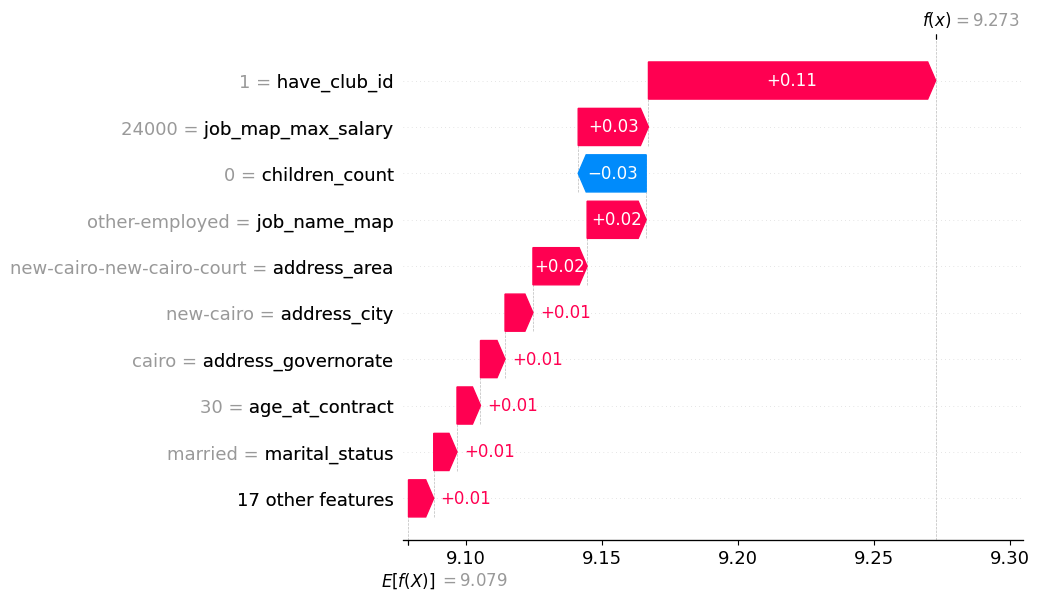

In [48]:
# Income reason
if run_type == 'bullet_test':
    income_reason_df = expl_income_model_output(income_model_explainer, def_df[income_model_feats_names], plot=True)
    # display(income_reason_df) 

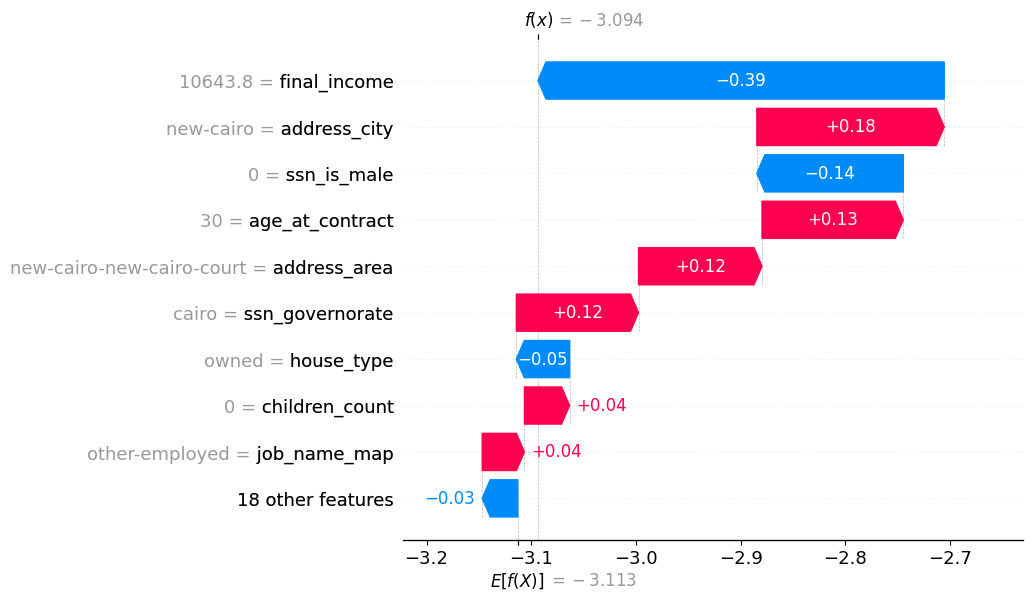

In [49]:
# PD reason
if run_type == 'bullet_test':
    pd_reasoning_df = expl_pd_model_output(pd_model_explainer, def_df[pd_model_feats_names], plot=True)
    # display(pd_reasoning_df)